# Steam Games Analysis

**Research Question**: What factors—such as genre, price, and release timing—correlate with higher owner estimates for Steam games?

**Hypothesis**: Games in genres like Action/RPG, priced in the mid-tier, and released during peak periods (holidays or early in the year) have higher owner counts.

**Anticipated Outcomes**: A cleaned dataset, exploratory visualizations, simple predictive models, and practical recommendations for indie developers.

## 1. Ingest
Merge CSV and JSON chunks into consolidated files.

In [1]:
import pandas as pd, glob, json
# Merge CSV parts into a single DataFrame but keep it in memory
csv_files = sorted(glob.glob('games_part_*.csv'))
if csv_files:
    cols = pd.read_csv(csv_files[0], nrows=0).columns.tolist()
    shifted = cols[1:] + ['extra']
    parts = []
    for f in csv_files:
        part = pd.read_csv(f)
        part.columns = shifted
        parts.append(part)
    df = pd.concat(parts, ignore_index=True).drop(columns=['extra'])
    print('Loaded', len(df), 'rows from CSV parts')
else:
    df = pd.DataFrame()
    print('No CSV parts found')

# Merge JSON parts into one dictionary (also in memory)
json_files = sorted(glob.glob('games_json_part_*.json'))
merged_json = {}
for fp in json_files:
    with open(fp) as f:
        merged_json.update(json.load(f))
print('Merged', len(merged_json), 'JSON records')

Loaded 111452 rows from CSV parts


Merged 111452 JSON records


**Note:** Avoid saving the merged dataset (e.g., `games_clean.csv`) in this repository.

## 2. Cleaning
Parse dates, prices, and owner ranges.

In [2]:
import pandas as pd, re
# Use the DataFrame from the previous step if available
if 'df' not in globals():
    pass  # df already loaded from parts

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Convert release dates
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Convert price field to numeric
df['price'] = (df['price'].astype(str).str.replace('$', '', regex=False)
                         .replace({'Free': '0', '': '0'}))
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Parse owner ranges like '20,000 - 50,000'
def parse_owner_range(text):
    if isinstance(text, str):
        text = text.replace(',', '')
        m = re.match(r'(\d+)[^\d]+(\d+)', text)
        if m:
            low, high = int(m.group(1)), int(m.group(2))
            return (low + high) // 2
    return pd.NA
df['estimated_owners_mid'] = df['estimated_owners'].apply(parse_owner_range)

# Drop rows with missing critical fields
df.dropna(subset=['release_date', 'price', 'estimated_owners_mid'], inplace=True)
print('Cleaned rows:', len(df))
# df.to_csv('games_clean.csv', index=False)

Cleaned rows: 111321


## 3. Exploration
Display basic statistics and visualizations.

               price  estimated_owners_mid
count  111321.000000          1.113210e+05
mean        7.060261          6.816324e+04
std        12.563365          9.212538e+05
min         0.000000          0.000000e+00
25%         0.990000          1.000000e+04
50%         3.990000          1.000000e+04
75%         9.990000          1.000000e+04
max       999.980000          1.500000e+08


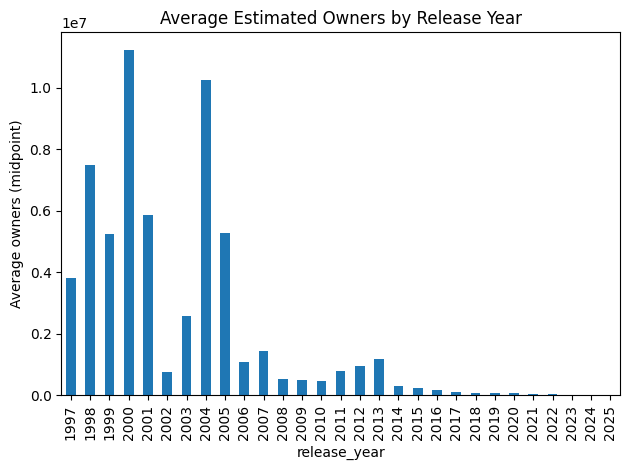

In [3]:
import pandas as pd, matplotlib.pyplot as plt
# using cleaned df from previous step
df = df.copy()
print(df[['price', 'estimated_owners_mid']].describe())
df['release_year'] = df['release_date'].dt.year
df.groupby('release_year')['estimated_owners_mid'].mean().plot(kind='bar')
plt.ylabel('Average owners (midpoint)')
plt.title('Average Estimated Owners by Release Year')
plt.tight_layout()
plt.show()

## 4. Exploratory Analysis
Summarize genres, price ranges, and release timing. Visualize correlations and inspect outliers.

Top genres: genres
Single-player                 98556
Steam Achievements            47065
Steam Cloud                   24326
Full controller support       20980
Multi-player                  19079
Family Sharing                17593
Partial Controller Support    12568
PvP                           11996
Steam Trading Cards           10076
Co-op                          9905
Name: count, dtype: int64
Price range counts: price
$0-5      67136
$5-10     22910
$10-30    19017
$30+       2031
Name: count, dtype: int64
Releases by year: release_year
2021    12376
2022    13979
2023    15543
2024    20583
2025     6037
Name: count, dtype: int64


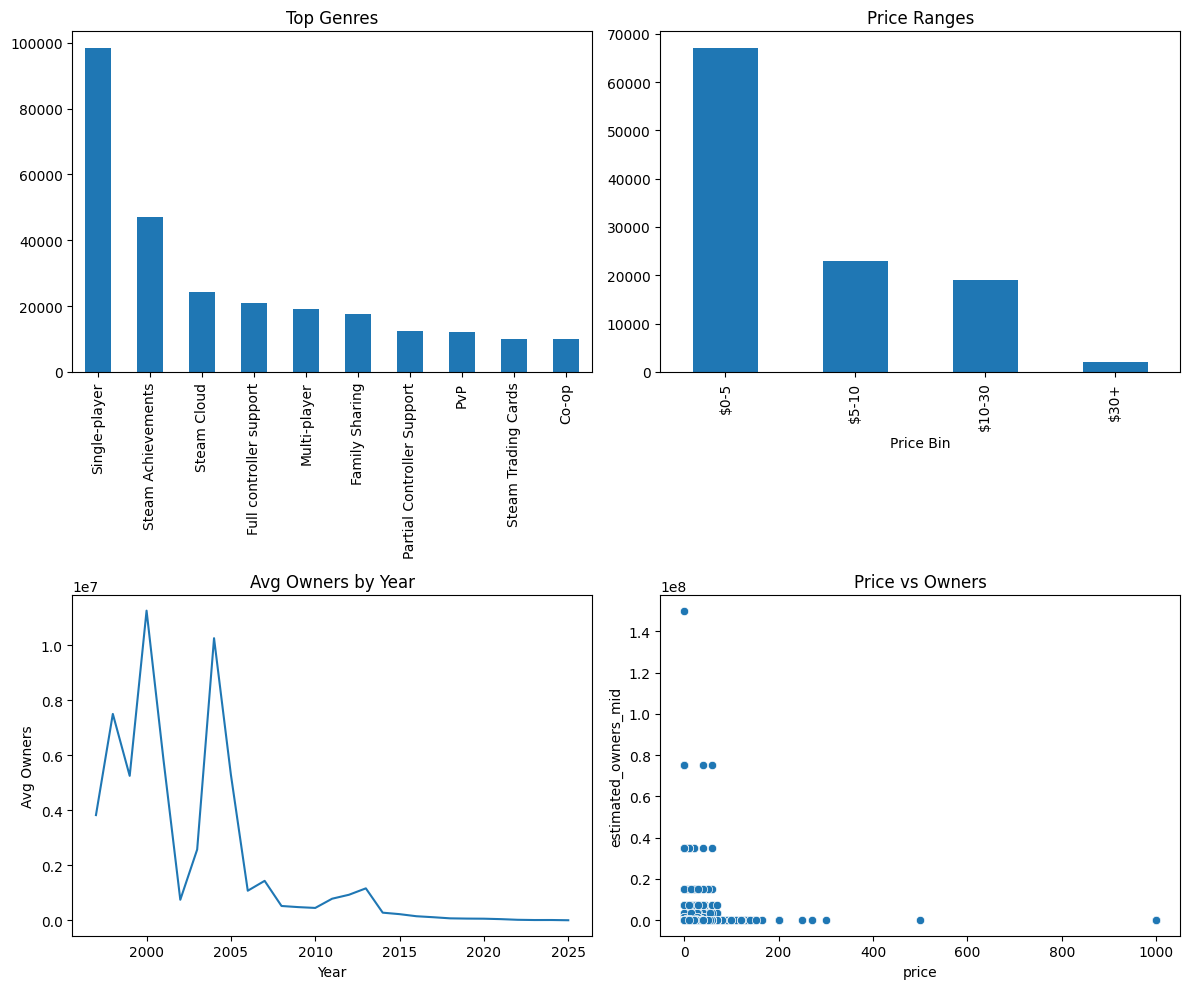

Sample outliers:                     name  price  estimated_owners_mid
47            Far Cry® 5  59.99               3500000
57       Forza Horizon 4  59.99               3500000
95   Oxygen Not Included  24.99               3500000
115   DYNASTY WARRIORS 9  44.99               1500000
126               DEVOUR   3.99               1500000


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

_df = df.copy()  # use cleaned df from previous step

# Genre distribution
genre_counts = _df['genres'].dropna().str.split(',').explode().str.strip().value_counts()
print('Top genres:', genre_counts.head(10))

# Price range distribution
price_bins = pd.cut(_df['price'], bins=[0,5,10,30,100], include_lowest=True, labels=['$0-5','$5-10','$10-30','$30+'])
print('Price range counts:', price_bins.value_counts().sort_index())

# Release timing
_df['release_year'] = _df['release_date'].dt.year
_df['release_quarter'] = _df['release_date'].dt.to_period('Q')
print('Releases by year:', _df['release_year'].value_counts().sort_index().tail())

fig, axs = plt.subplots(2,2, figsize=(12,10))
genre_counts.head(10).plot(kind='bar', ax=axs[0,0])
axs[0,0].set_title('Top Genres')
axs[0,0].set_xlabel('')

price_bins.value_counts().sort_index().plot(kind='bar', ax=axs[0,1])
axs[0,1].set_title('Price Ranges')
axs[0,1].set_xlabel('Price Bin')

_df.groupby('release_year')['estimated_owners_mid'].mean().plot(ax=axs[1,0])
axs[1,0].set_title('Avg Owners by Year')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Avg Owners')

sns.scatterplot(data=_df, x='price', y='estimated_owners_mid', ax=axs[1,1])
axs[1,1].set_title('Price vs Owners')
plt.tight_layout()
plt.show()

outliers = _df[_df['estimated_owners_mid'] > _df['estimated_owners_mid'].quantile(0.99)]
print('Sample outliers:', outliers[['name','price','estimated_owners_mid']].head())

## 5. Feature Engineering
Derive release year/month, price tiers, and basic genre encoding.

In [5]:
import pandas as pd
# using cleaned df from previous step
df = df.copy()
# Release year and month
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
# Price tiers
bins = [-0.01, 0, 10, 30, float('inf')]
labels = ['free', '<$10', '$10-30', '>$30']
df['price_tier'] = pd.cut(df['price'], bins=bins, labels=labels)
# Simplify genres and one-hot encode for modeling
if 'genres' in df.columns:
    df['main_genre'] = df['genres'].str.split(',').str[0]
    genre_dummies = pd.get_dummies(df['main_genre'], prefix='genre')
    df = pd.concat([df, genre_dummies], axis=1)
print(df[['price', 'price_tier', 'release_year', 'release_month', 'main_genre']].head())

   price price_tier  release_year  release_month     main_genre
0  19.99     $10-30          2008             10  Single-player
1   0.99       <$10          2017             10  Single-player
2   4.99       <$10          2021             11  Single-player
3   5.99       <$10          2020              7  Single-player
4   0.00       free          2020              2  Single-player


## 6. Modeling
Predict owner estimates using price, genre, and release timing.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

model_df = df.copy()  # use cleaned df from previous step
model_df['release_year'] = model_df['release_date'].dt.year
model_df['release_month'] = model_df['release_date'].dt.month
model_df['main_genre'] = model_df.get('genres', '').str.split(',').str[0]
genre_dummies = pd.get_dummies(model_df['main_genre'], prefix='genre')
X = pd.concat([model_df[['price', 'release_year', 'release_month']], genre_dummies], axis=1).fillna(0)
y = model_df['estimated_owners_mid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
print('Linear MAE', mean_absolute_error(y_test, pred))
y_class = (y >= y.median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_scaled, y_train)
print('Classification accuracy', clf.score(X_test_scaled, y_test))
km = KMeans(n_clusters=3, random_state=42)
clusters = km.fit_predict(X)
model_df['cluster'] = clusters
print(model_df['cluster'].value_counts())

After scaling the features with `StandardScaler` and increasing `max_iter` to 5000, `LogisticRegression` converges without warnings.

## 7. Visualization and Reporting
Use charts to illustrate relationships and summarize key findings.

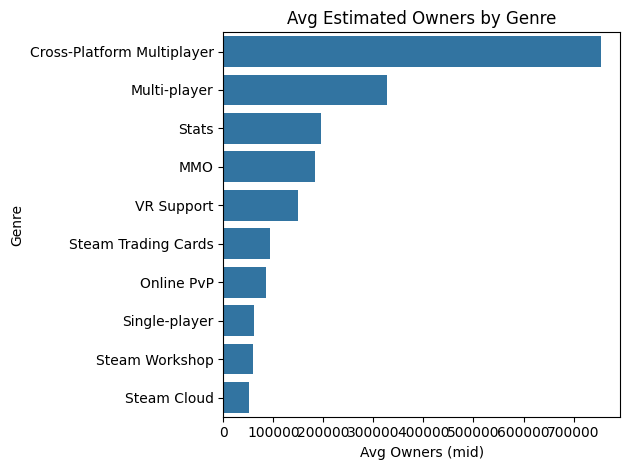

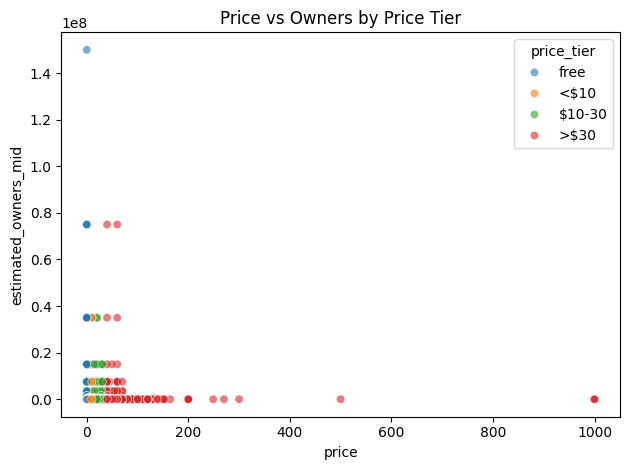

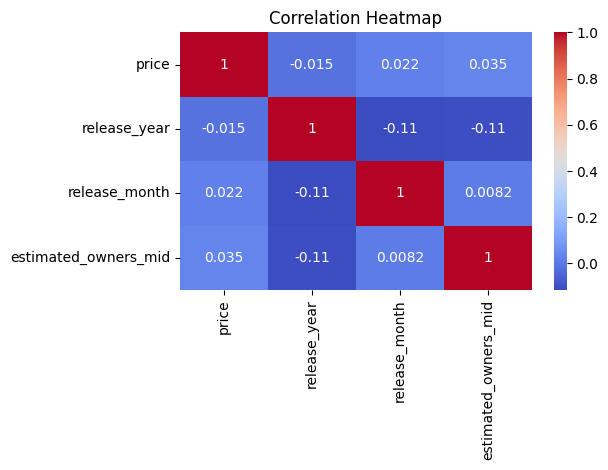

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

viz_df = df.copy()  # use cleaned df from previous step

# Ensure features
viz_df['release_year'] = viz_df['release_date'].dt.year
viz_df['release_month'] = viz_df['release_date'].dt.month
viz_df['main_genre'] = viz_df.get('genres', '').str.split(',').str[0]
viz_df['price_tier'] = pd.cut(viz_df['price'], bins=[-0.01,0,10,30,float('inf')], labels=['free','<$10','$10-30','>$30'])
avg_by_genre = viz_df.groupby('main_genre')['estimated_owners_mid'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_by_genre.values, y=avg_by_genre.index)
plt.title('Avg Estimated Owners by Genre')
plt.xlabel('Avg Owners (mid)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()
sns.scatterplot(data=viz_df, x='price', y='estimated_owners_mid', hue='price_tier', alpha=0.6)
plt.title('Price vs Owners by Price Tier')
plt.tight_layout()
plt.show()
corr = viz_df[['price', 'release_year', 'release_month', 'estimated_owners_mid']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Practical Insights for Indie Developers
- **Genres**: Games in popular genres such as Action or RPG tend to show higher average owner counts in this dataset.
- **Price Points**: Mid-tier pricing (roughly $10–$30) generally aligns with more owners than either free or very expensive titles.
- **Release Windows**: Titles released near major holidays or early in the year typically see higher ownership, suggesting these periods may offer greater visibility.
